# Homework 3
#### Name: Priyam Mazumdar
#### NetID: priyamm2

In [1]:
# Load Required Packages
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## Question 1 [50 Points] A Simulation Study

Let's use a simulation study to confirm the bias-variance trade-off of linear regressions. Consider the following model. 

$$Y = \sum_j^p 0.8^j \times X_j + \epsilon$$
All the covariates and the error term follow i.i.d. standard Gaussian distribution. The true model involves all the variables; however, larger indexes do not significantly contribute to the variation. Hence, there could be a benefit in using a smaller subset for prediction purposes. Let's confirm that with a simulation study. 
- Generate 100 samples of covariates $X$ with $p=30$ by the following code.


  - Then the study essentially **repeats** the following steps 100 times. Begin with another fixed random seed before your loop.
    - Using the fixed covariates $X$, generate 100 training outcomes $Y_\text{train}$ and 100 testing outcomes $Y_\text{test}$ independently.
    - Consider using only the first $j$ variables to fit the linear regression (**NO intercept term**). Let $j$ ranges from 1 to 30. Calculate and record the corresponding prediction error by comparing your prediction with the outcomes for testing data. 

**Without running the simulation**, for each $j$ value, we also have the theoretical decomposition of the testing error based on the lecture. Suppose you know the true model, covariates $X$ and the distribution of random noise.

  a) [15 pts]  Please calculate the bias^2 , variance (of the prediction) and testing error for each $j$ based on the theoretical formulas. Plot the 3 lines on the same figure,  using the `number of variables` as the x-axis and `bias^2`, `variance`, `theoretical testing error`  as the y-axis. Label each line.
   - $\text{Bias}^2 = \frac{1}{n} \| E(Y_\text{pred}) - Y_\text{true} \|^2$, where $Y$ is an $n \times 1$ vector.
   - $\text{Var} =  \frac{1}{n} E \| Y_\text{pred} - E(Y_\text{pred}) \|^2$.
    

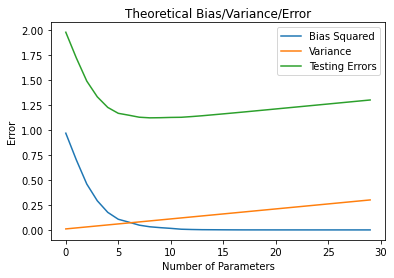

In [2]:
# Generate Data
np.random.seed(542)
n = 100
p = 30
b = np.array([0.8 ** i for i in range(1, p+1)]).reshape(p,1)
X = np.random.standard_normal(size=(n,p))

# Calculate Bias
H = X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T)
u = X.dot(b)

bias_values = []
variance_values = []
testing_errors = []
for idx in range(len(b)):
    current_x = X[:, :idx+1]
    current_h = current_x.dot(np.linalg.inv(current_x.T.dot(current_x))).dot(current_x.T)
    bias2 = ((u - current_h.dot(u))**2).mean()
    bias_values.append(bias2)
    variance_values.append((idx+1)/n)
    testing_errors.append(1 + bias2 + (idx+1)/n)
    
plt.plot(bias_values, label="Bias Squared")
plt.plot(variance_values, label="Variance")
plt.plot(testing_errors, label="Testing Errors")
plt.title("Theoretical Bias/Variance/Error")
plt.xlabel("Number of Parameters")
plt.ylabel("Error")
plt.legend()

  b) [5 pts] Report the theoretical testing error with $p = 30$, $\frac{1}{n}E \|Y_\text{test} - Y_\text{pred} \|^2$.

In [3]:
print("Theoretical Testing Error with P = 30:", testing_errors[-1])

Theoretical Testing Error with P = 30: 1.3


**After finishing the simulation**:

  c)  [20 pts]  Perform the simulation. Report the averaged (empirical) prediction error with $p = 30$. Note that 100 times simulation approximates the $E$ operation. Plot `pred err` in the **same figure** of question a. Label your line. Does your empirical testing error match our theoretical analysis? Comment on your findings.

In [4]:
mean_errors = []
y_trains = []
y_tests = []

# Create a list of 100 samples of y trains and test based on X and b
for i in range(100): 
    y_trains.append(X.dot(b)+np.random.standard_normal(size=(100,1)))
    y_tests.append(X.dot(b)+np.random.standard_normal(size=(100,1)))
    
for i in range(1,p+1): 
    errors = []
    for j in range(100):
        y_train, y_test = y_trains[j], y_tests[j]
        x_sub = X[:,:i]
        model = LinearRegression().fit(x_sub,y_train)
        errors.append(mean_squared_error(y_test,model.predict(x_sub)))
    mean_errors.append(np.mean(errors))
    

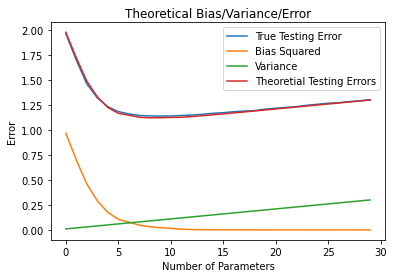

In [5]:
plt.plot(mean_errors, label="True Testing Error")
plt.plot(bias_values, label="Bias Squared")
plt.plot(variance_values, label="Variance")
plt.plot(testing_errors, label="Theoretial Testing Errors")
plt.title("Theoretical Bias/Variance/Error")
plt.xlabel("Number of Parameters")
plt.ylabel("Error")
plt.legend()

We can see that our true testing error calculated from simulation and the theoretical testing error are nearly identical. This shows that given our Betas, we can accurately estimate the testing error based on the number of predictors used. 

We aso see that our testing error was minimized around 9 parameters, and adding more paramters after that only hurt our model performance. 

  d)  [10 pts]  Evaluate the bias^2 for model $p=5$ without theoretical formulas. You can still assume you know the true outcomes while using the average results to approximate the $E$ operation. Compare the empirical value with the theoretical one.

In [6]:
bias_list = []

for sim in range(100):
    y_train = y_trains[sim]
    y_test = y_tests[sim]
    x_sub = X[:, :5]
    model=LinearRegression().fit(x_sub, y_train)
    y_pred = model.predict(x_sub)
    bias = np.mean((y_test-y_pred)**2)
    
print("Theoretical Bias:", bias_values[4])   
print("Simulated Bias:", np.array(bias).mean())

Theoretical Bias: 0.17563088770223498
Simulated Bias: 1.2291153994161765


## Question 2 [50 Points] Bitcoin price prediction

For this question, we will use the [Bitcoin data]() provided on the course website. The data were posted originally on Kaggle ([link](https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory?select=bitcoin_cash_price.csv)). Make sure that you read relevant information from the Kaggle website. Our data is the `bitcoin_dataset.csv` file. You should use a training/testing split such that your training data is constructed using only information up to 12/31/2016, and your testing data is constructed using only information starting from 01/01/2017. The goal of our analysis is to predict the `btc_market_price`. Since this is longitudinal data, we will use the information from previous days to predict the market price at a future day. In particular, on each calendar day (say, day 1), we use the information from three days onward (days 1, 2, and 3) to predict the market price on the 7th day. 

Hence you need to first reconstruct the data properly to fit this purpose. This is mainly to put the outcome (of day 7) and the covariates (of the previous days) into the same row. Note that you may face missing data, categorical predictors, outliers, scaling issues, computational issues, and maybe others for this question. Use your best judgment to deal with them. There is no general ``best answer''. Hence the grading will be based on whether you provided reasoning for your decision and whether you carried out the analysis correctly.

a.  [25 Points] Data Construction. Data pre-processing is usually the most time-consuming and difficult part of an analysis. We will use this example as a practice. Construct your data appropriately such that further analysis can be performed. Make sure that you consider the following:

    * The data is appropriate for our analysis goal: each row contains the outcome on the seventh day and the covariates based on the first three days. The covariates are not limited to the price.
    * Missing data is addressed (you can remove variables, remove observations, impute values or propose your own method)
    * You may process the covariates and/or outcome by considering centering, scaling, transformation, removing outliers, etc. However, these are your choice. 
  
For each of the above tasks, make sure that you **clearly document your choice**. In the end, provide a summary table/figure of your data. You can consider using boxplots, quantiles, histograms, or any method that is easy for readers to understand. You are required to pick at least one method to present. 



In [7]:
# Load Data 
data = pd.read_csv("bitcoin.csv")

# Check for NAs
missing_values = data.isnull().sum()[data.isnull().sum()>0]

We can see that we have 21 missing values in our data in the btc_trade_volume column so we can use interpolation by filling an NA with the average of the point before and after. Now we can apply some light post processing to column names, realign our data and split into train and test. 

In [8]:
# Interpolate 
data["btc_trade_volume"] = data["btc_trade_volume"].interpolate()

# Preprocess Columns
data = data.rename(columns={"Date":"date"})
data["date"] = pd.to_datetime(data["date"])
data = data.sort_values(by="date", ascending=False).reset_index(drop=True)

# Split train and test data
train_data = data[data["date"] <= "2016-12-31"].reset_index(drop=True)
test_data = data[data["date"] > "2016-12-31"].reset_index(drop=True)

# Get target price chart
price_chart = train_data[["date", "btc_market_price"]]

def alignData(dataframe):
    # Pull price chart out
    price_chart = dataframe[["date", "btc_market_price"]]
    
    # Set the date as index
    dataframe = dataframe.set_index("date")
    
    # Go back 4, 5, and 6, days (5, 6, and 7 with 0 index) and 
    # shift dataframe to align idx days previous to current day
    # store dataframe in list
    
    dataframe_list = []
    for shift in [-5, -6, -7]:
        shifted = dataframe.shift(shift)
        dataframe_list.append(shifted)
    
    # Loop through shifted dataframes and rename columns indicating # of days previous
    for idx, data in enumerate(dataframe_list):
        days_back = 4 + idx
        cols = [f"{days_back}_days_prev_{col}" for col in data.columns]
        data.columns = cols
        dataframe_list[idx] = data
        
    # Concatenate all dataframes in list and merge on price chart
    data_concat = pd.concat(dataframe_list, axis=1).reset_index()
    merged_data = pd.merge(price_chart, data_concat, on="date", how="left")
    merged_data = merged_data.rename(columns={"btc_market_price":"target_price"})
    merged_data = merged_data.set_index("date")
    merged_data = merged_data.loc[:,~merged_data.columns.duplicated()]
    return merged_data

train_data = alignData(train_data)
test_data = alignData(test_data)

### Feature Engineering
We can expect that because most columns are just a shifted version of the original, we will see some heavy correlation between them. Do handle this we want to first check the correlation matrix and a boxplot of all the columns to make sure we have well adjusted data.

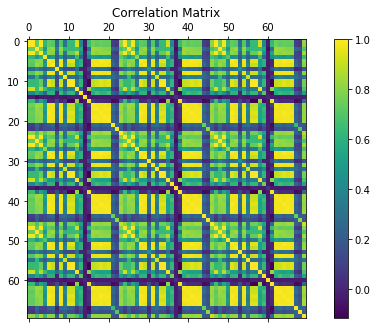

In [9]:
f = plt.figure(figsize=(10, 5))
plt.matshow(train_data.corr(), fignum=f.number)
plt.title("Correlation Matrix")
cb = plt.colorbar()

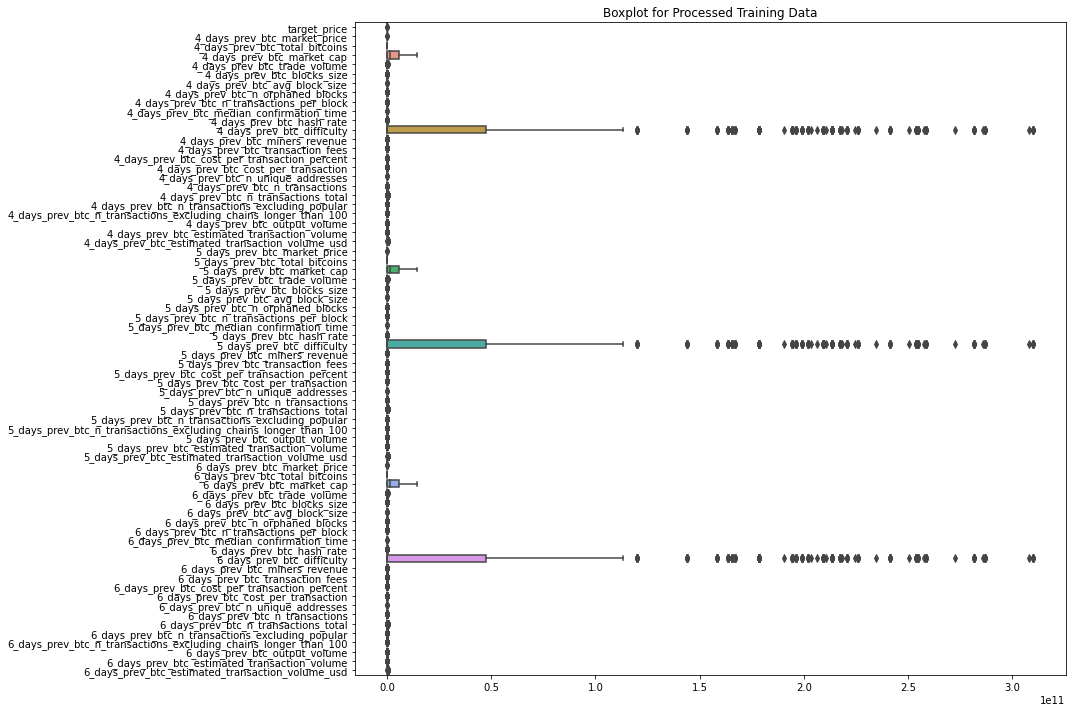

In [10]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(data=train_data,orient='h')
plt.title('Boxplot for Processed Training Data')
plt.tight_layout()
plt.show()

Looking at our data we can see a couple of glaring issue:
- High correlation between many pairs of variables
- No proper scaling between variables

To fix this we will take our data and perform the removal of columns that have high correlation (greater than 0.95) as well as normalize all the columns to alleviate this. 

In [11]:
# Store targets
target_train = train_data["target_price"].reset_index()
target_test = test_data["target_price"].reset_index()

# Drop columns with greater than 0.95 correlation
correlation_table = train_data.corr()
uncorrelated_cols = ~(correlation_table.mask(np.eye(len(correlation_table), dtype=bool)).abs() > 0.95).any()
train_data_uncorr = train_data[list(uncorrelated_cols[uncorrelated_cols == True].reset_index()["index"])]
test_data_uncorr = test_data[list(uncorrelated_cols[uncorrelated_cols == True].reset_index()["index"])]

scaler = StandardScaler()
# Scale Training Data
scale_train = pd.DataFrame(scaler.fit_transform(train_data_uncorr))
scale_train.columns = train_data_uncorr.columns
scale_train_data = pd.concat([target_train, scale_train], axis=1)

# Scale testing data
scale_test = pd.DataFrame(scaler.transform(test_data_uncorr))
scale_test.columns = train_data_uncorr.columns
scale_test_data = pd.concat([target_test, scale_test], axis=1)

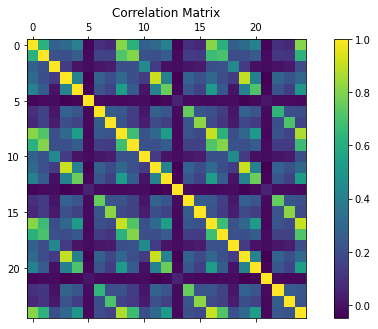

In [12]:
f = plt.figure(figsize=(10, 5))
plt.matshow(scale_train_data.corr(), fignum=f.number)
plt.title("Correlation Matrix")
cb = plt.colorbar()

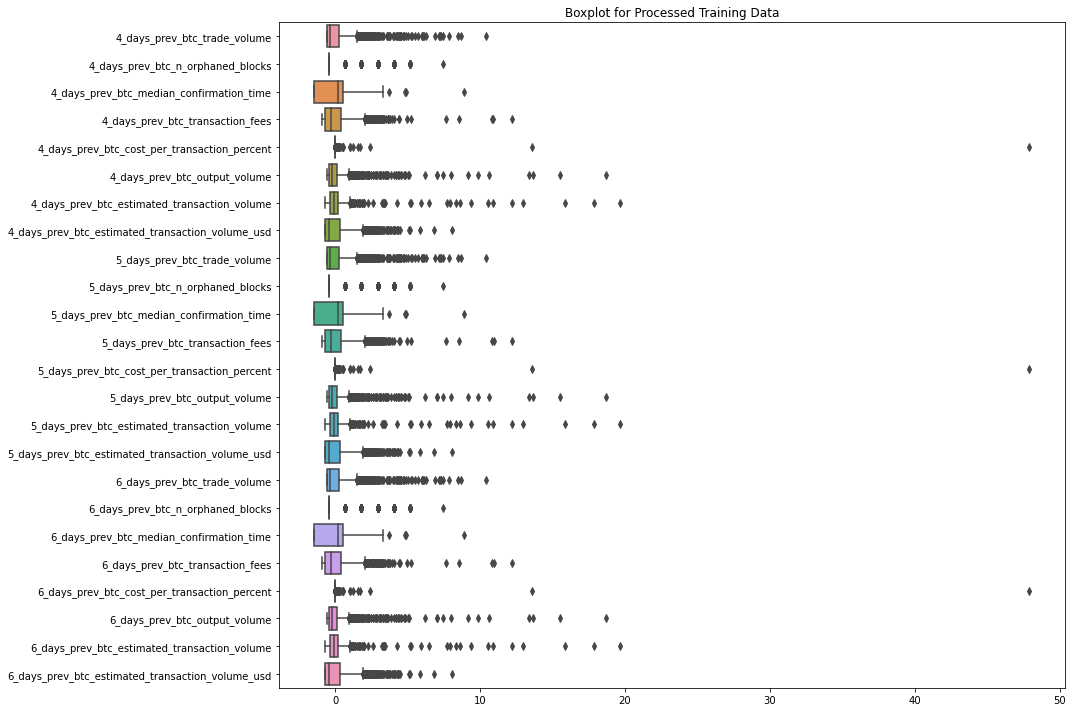

In [13]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(data=scale_train_data.loc[:,scale_train_data.columns != "target_price"],orient='h')
plt.title('Boxplot for Processed Training Data')
plt.tight_layout()
plt.show()

We can now see that we have much fewer predictors and all are well scaled to be used for prediction purposes. Becuase python does not have a package for Forward/Backward elimination, I will be storing my training data and doing the remaining analysis in R.

In [14]:
scale_train_data.set_index("date").to_csv("train_data.csv", index=False)
scale_test_data.set_index("date").to_csv("test_data.csv", index=False)